# Imports and Data Preparation

In [ ]:
!pip install grad-cam kaggle pillow matplotlib scikit-learn -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
import copy
import kagglehub

# 1. SETUP & DATA PREPARATION
print("Downloading/Loading Dataset...")
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
data_dir = Path(path) / "COVID-19_Radiography_Dataset"

# Define Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset Class
class COVID19Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Prepare Data Lists
classes = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
class_names = classes
image_paths = []
labels = []

print("Indexing files...")
for label, class_name in enumerate(classes):
    class_dir = data_dir / class_name / 'images'
    if not class_dir.exists():
        class_dir = data_dir / class_name

    # Limit data for speed (remove [:500] for full training)
    files = list(class_dir.glob('*.png'))[:500]
    for img_path in files:
        image_paths.append(str(img_path))
        labels.append(label)

# --- SPLIT 1: Hold out 15% for FINAL TESTING (Separate Test Set) ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)

# Create the Final Test Loader (Held-out)
test_dataset = COVID19Dataset(X_test, y_test, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Data ready.")
print(f"K-Fold Training Data: {len(X_train_val)} images")
print(f"Held-out Test Data:   {len(X_test)} images")
print(f"Device: {device}")

Downloading/Loading Dataset...
Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Indexing files...
Data ready.
K-Fold Training Data: 1700 images
Held-out Test Data:   300 images
Device: cuda


# Model Definitions

In [ ]:
# A. ResNet50
def get_resnet():
    model = models.resnet50(weights='DEFAULT')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(classes))
    return model.to(device)

# B. DenseNet121
def get_densenet():
    model = models.densenet121(weights='DEFAULT')
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(classes))
    return model.to(device)

# C. Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_simple_cnn():
    return SimpleCNN(len(classes)).to(device)

# Training Function

In [ ]:
def train_kfold(model_init_func, name, X_data, y_data, test_loader, k_folds=5, epochs=1):
    print(f"\n{'='*20} Processing {name} ({k_folds}-Fold CV) {'='*20}")
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Tracking variables
    best_model_wts = None
    best_overall_acc = 0.0
    best_fold_idx = 0

    # Store history for all folds: {fold_index: {'train_loss': [], ...}}
    all_fold_histories = {}

    X_arr = np.array(X_data)
    y_arr = np.array(y_data)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_arr, y_arr)):
        print(f"\n--- Fold {fold+1}/{k_folds} ---")

        # 1. Setup Fold Data
        train_ds = COVID19Dataset(X_arr[train_idx], y_arr[train_idx], transform=data_transforms)
        val_ds = COVID19Dataset(X_arr[val_idx], y_arr[val_idx], transform=data_transforms)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

        # 2. Init Model
        model = model_init_func()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 3. History for this fold
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Train
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            train_loss = running_loss / len(train_loader)

            # Val
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_acc = 100 * val_correct / val_total
            val_loss = val_loss / len(val_loader)

            # Store Metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Ep {epoch+1} | T_Loss:{train_loss:.3f} T_Acc:{train_acc:.1f}% | V_Loss:{val_loss:.3f} V_Acc:{val_acc:.1f}%")

            # Check for best model
            if val_acc > best_overall_acc:
                best_overall_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_fold_idx = fold

        all_fold_histories[fold] = history

    # --- End of CV ---
    print(f"\nBest Validation Accuracy: {best_overall_acc:.2f}% (Found in Fold {best_fold_idx+1})")

    # Evaluate Best Model on Held-out Test Set
    print(f"Evaluating Best Model on Held-out Test Set...")
    final_model = model_init_func()
    final_model.load_state_dict(best_model_wts)
    final_model.eval()

    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f">>> Held-out Test Set Accuracy: {test_acc:.2f}%")

    return final_model, all_fold_histories[best_fold_idx]

# Run Training


==================== Processing ResNet50 (3-Fold CV) ====================

--- Fold 1/3 ---
Ep 1 | T_Loss:0.641 T_Acc:74.9% | V_Loss:1.822 V_Acc:55.2%
Ep 2 | T_Loss:0.341 T_Acc:87.5% | V_Loss:0.920 V_Acc:69.8%
Ep 3 | T_Loss:0.244 T_Acc:91.5% | V_Loss:0.719 V_Acc:73.7%
Ep 4 | T_Loss:0.141 T_Acc:95.0% | V_Loss:0.330 V_Acc:86.2%
Ep 5 | T_Loss:0.123 T_Acc:95.2% | V_Loss:0.315 V_Acc:89.4%
Ep 6 | T_Loss:0.094 T_Acc:97.6% | V_Loss:0.539 V_Acc:82.0%
Ep 7 | T_Loss:0.128 T_Acc:95.8% | V_Loss:0.365 V_Acc:87.8%
Ep 8 | T_Loss:0.039 T_Acc:98.9% | V_Loss:0.321 V_Acc:90.8%
Ep 9 | T_Loss:0.046 T_Acc:98.4% | V_Loss:1.112 V_Acc:78.8%
Ep 10 | T_Loss:0.152 T_Acc:94.5% | V_Loss:0.450 V_Acc:84.3%

--- Fold 2/3 ---
Ep 1 | T_Loss:0.618 T_Acc:77.2% | V_Loss:1.177 V_Acc:66.1%
Ep 2 | T_Loss:0.296 T_Acc:90.0% | V_Loss:1.458 V_Acc:66.1%
Ep 3 | T_Loss:0.200 T_Acc:92.9% | V_Loss:0.848 V_Acc:74.3%
Ep 4 | T_Loss:0.182 T_Acc:93.3% | V_Loss:0.403 V_Acc:86.6%
Ep 5 | T_Loss:0.127 T_Acc:95.5% | V_Loss:0.474 V_Acc:85.5%
Ep 

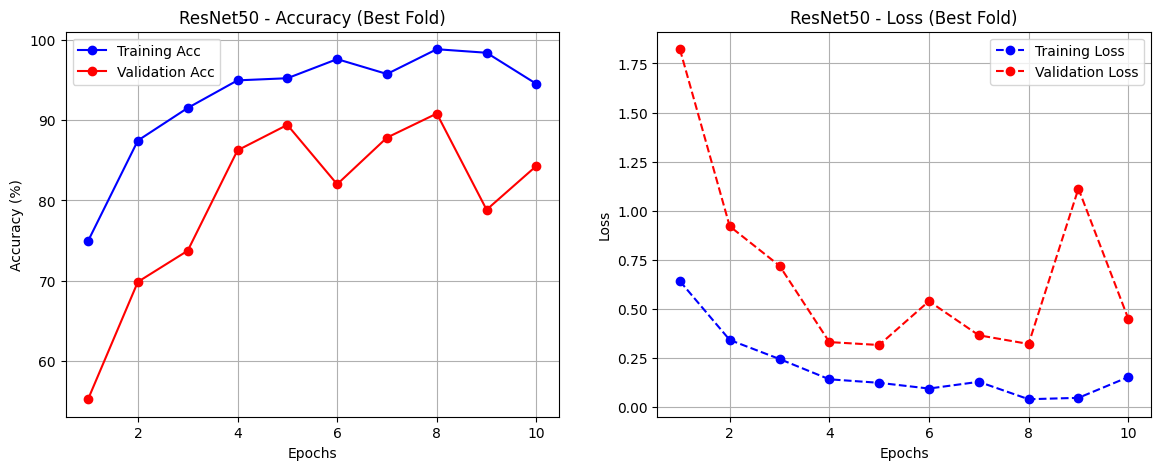


==================== Processing DenseNet121 (3-Fold CV) ====================

--- Fold 1/3 ---
Ep 1 | T_Loss:0.583 T_Acc:76.9% | V_Loss:0.472 V_Acc:81.7%
Ep 2 | T_Loss:0.271 T_Acc:89.0% | V_Loss:0.872 V_Acc:68.4%
Ep 3 | T_Loss:0.214 T_Acc:91.5% | V_Loss:0.627 V_Acc:77.2%
Ep 4 | T_Loss:0.195 T_Acc:93.3% | V_Loss:0.541 V_Acc:82.4%
Ep 5 | T_Loss:0.181 T_Acc:93.3% | V_Loss:0.892 V_Acc:74.8%
Ep 6 | T_Loss:0.165 T_Acc:94.4% | V_Loss:1.309 V_Acc:66.5%
Ep 7 | T_Loss:0.221 T_Acc:92.1% | V_Loss:0.452 V_Acc:85.0%
Ep 8 | T_Loss:0.095 T_Acc:96.5% | V_Loss:0.595 V_Acc:85.4%
Ep 9 | T_Loss:0.083 T_Acc:96.9% | V_Loss:0.496 V_Acc:84.3%
Ep 10 | T_Loss:0.112 T_Acc:95.1% | V_Loss:0.319 V_Acc:89.8%

--- Fold 2/3 ---
Ep 1 | T_Loss:0.620 T_Acc:76.5% | V_Loss:6.947 V_Acc:42.5%
Ep 2 | T_Loss:0.325 T_Acc:88.3% | V_Loss:1.249 V_Acc:61.7%
Ep 3 | T_Loss:0.280 T_Acc:91.2% | V_Loss:0.382 V_Acc:85.5%
Ep 4 | T_Loss:0.209 T_Acc:91.6% | V_Loss:0.343 V_Acc:88.4%
Ep 5 | T_Loss:0.125 T_Acc:95.5% | V_Loss:0.527 V_Acc:83.8%


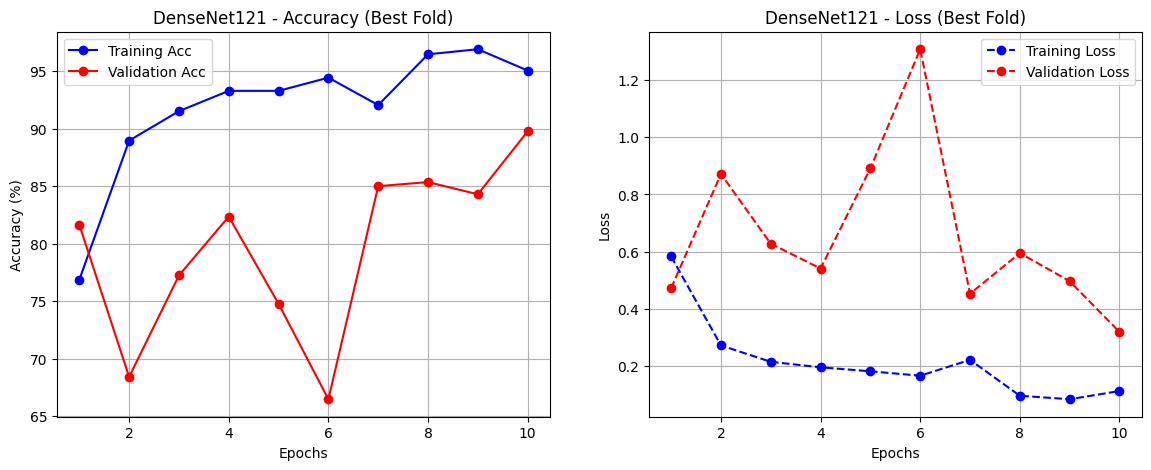


==================== Processing SimpleCNN (3-Fold CV) ====================

--- Fold 1/3 ---
Ep 1 | T_Loss:1.266 T_Acc:42.8% | V_Loss:0.977 V_Acc:61.7%
Ep 2 | T_Loss:0.948 T_Acc:58.4% | V_Loss:0.853 V_Acc:61.9%
Ep 3 | T_Loss:0.848 T_Acc:63.5% | V_Loss:0.783 V_Acc:65.4%
Ep 4 | T_Loss:0.759 T_Acc:69.1% | V_Loss:0.699 V_Acc:70.7%
Ep 5 | T_Loss:0.667 T_Acc:72.2% | V_Loss:0.614 V_Acc:75.0%
Ep 6 | T_Loss:0.589 T_Acc:76.6% | V_Loss:0.537 V_Acc:77.8%
Ep 7 | T_Loss:0.475 T_Acc:83.0% | V_Loss:0.519 V_Acc:79.7%
Ep 8 | T_Loss:0.371 T_Acc:86.1% | V_Loss:0.512 V_Acc:79.7%
Ep 9 | T_Loss:0.322 T_Acc:87.7% | V_Loss:0.470 V_Acc:82.0%
Ep 10 | T_Loss:0.240 T_Acc:91.4% | V_Loss:0.547 V_Acc:79.9%

--- Fold 2/3 ---
Ep 1 | T_Loss:1.237 T_Acc:48.8% | V_Loss:0.929 V_Acc:59.8%
Ep 2 | T_Loss:0.859 T_Acc:62.8% | V_Loss:0.945 V_Acc:62.3%
Ep 3 | T_Loss:0.810 T_Acc:65.9% | V_Loss:0.881 V_Acc:64.0%
Ep 4 | T_Loss:0.657 T_Acc:74.1% | V_Loss:0.726 V_Acc:70.4%
Ep 5 | T_Loss:0.576 T_Acc:77.9% | V_Loss:0.595 V_Acc:78.5%
Ep

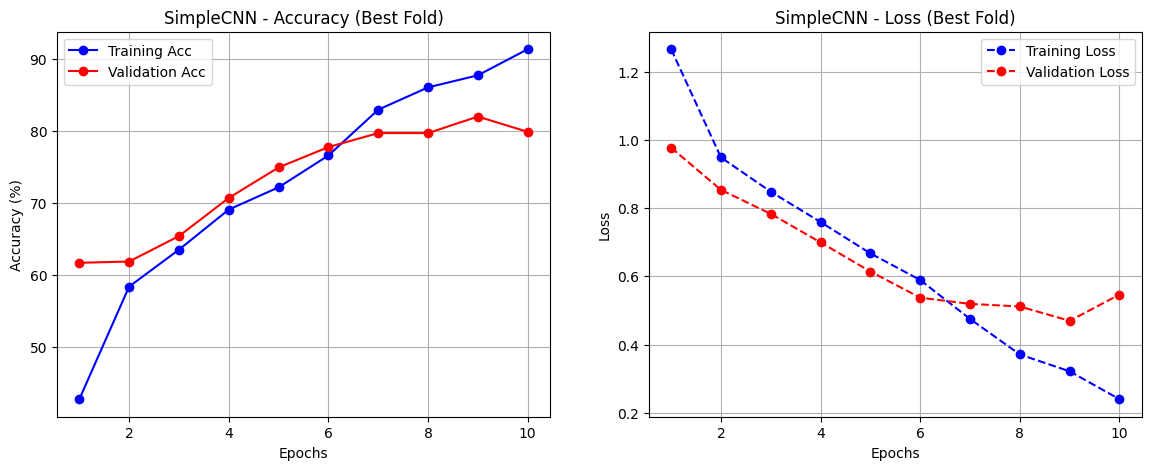

In [ ]:
def plot_history(history, title):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-o', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Acc')
    plt.title(f'{title} - Accuracy (Best Fold)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b--o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--o', label='Validation Loss')
    plt.title(f'{title} - Loss (Best Fold)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Run Training
K_FOLDS = 3
EPOCHS = 10

# 1. ResNet
resnet_model, resnet_hist = train_kfold(get_resnet, "ResNet50", X_train_val, y_train_val, test_loader, k_folds=K_FOLDS, epochs=EPOCHS)
plot_history(resnet_hist, "ResNet50")

# 2. DenseNet
densenet_model, densenet_hist = train_kfold(get_densenet, "DenseNet121", X_train_val, y_train_val, test_loader, k_folds=K_FOLDS, epochs=EPOCHS)
plot_history(densenet_hist, "DenseNet121")

# 3. Simple CNN
simple_model, simple_hist = train_kfold(get_simple_cnn, "SimpleCNN", X_train_val, y_train_val, test_loader, k_folds=K_FOLDS, epochs=EPOCHS)
plot_history(simple_hist, "SimpleCNN")

# Grad-CAM Comparison Function



In [ ]:
def compare_gradcam(models_dict, img_path):
    # Prepare Image
    rgb_img = Image.open(img_path).convert("RGB")
    rgb_img = rgb_img.resize((224, 224))
    rgb_img_float = np.float32(rgb_img) / 255
    input_tensor = data_transforms(rgb_img).unsqueeze(0).to(device)

    # Setup Plot
    fig, axes = plt.subplots(len(models_dict), 4, figsize=(20, 5 * len(models_dict)))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i, (name, model) in enumerate(models_dict.items()):
        model.eval()

        # 1. Get Prediction
        outputs = model(input_tensor)
        prob = torch.nn.functional.softmax(outputs, dim=1)
        pred_idx = torch.argmax(prob).item()
        pred_class = class_names[pred_idx]
        confidence = prob[0][pred_idx].item()

        # 2. Configure Grad-CAM Target Layer
        if "ResNet" in name:
            target_layers = [model.layer4[-1]]
        elif "DenseNet" in name:
            target_layers = [model.features[-1]]
        elif "Simple" in name:
            target_layers = [model.features[9]]

        # 3. Generate CAM
        cam = GradCAM(model=model, target_layers=target_layers)
        targets = [ClassifierOutputTarget(pred_idx)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        visualization = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)

        # 4. Plotting
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f"{name}\nPred: {pred_class} ({confidence:.1%})")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(grayscale_cam, cmap='jet')
        axes[i, 1].set_title("Grad-CAM Heatmap")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(visualization)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis('off')

        probs = prob.cpu().detach().numpy()[0]
        axes[i, 3].barh(class_names, probs, color='skyblue')
        axes[i, 3].set_xlim(0, 1.0)
        axes[i, 3].set_title("Class Probabilities")

    plt.show()

# Comparison

Analyzing image: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-469.png


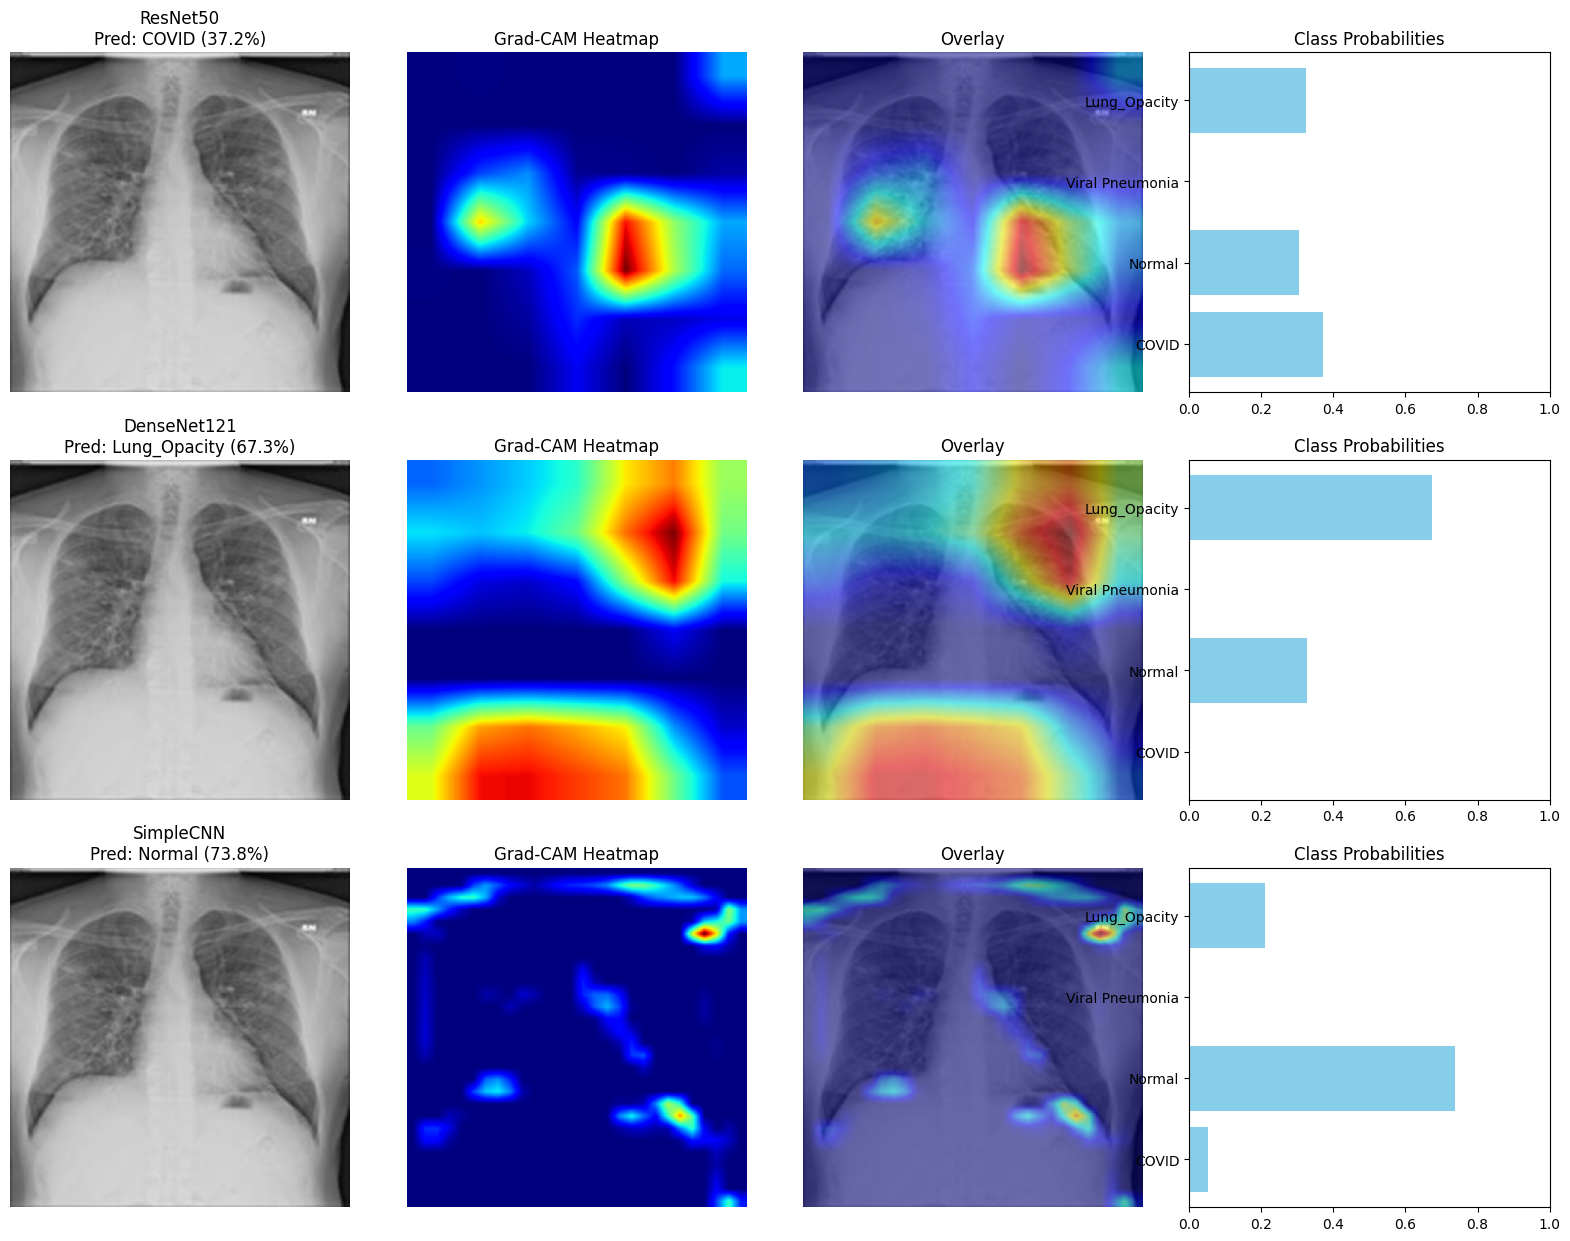

In [ ]:
import random

sample_image = random.choice(X_test)
print(f"Analyzing image: {sample_image}")

models_to_compare = {
    "ResNet50": resnet_model,
    "DenseNet121": densenet_model,
    "SimpleCNN": simple_model
}

compare_gradcam(models_to_compare, sample_image)